This notebook converts `samples.npy` to `fingerprints.npy`. After processing, check the max and mean images to make sure that you are not over- or under-cropping the data. Set `crop_rows` or `crop_cols` to `None` to see all the data.

In [1]:
data_root = 'drumData'
n_fft = 1024
hop_length = n_fft/4
use_logamp = False # boost the brightness of quiet sounds
reduce_rows = 10 # how many frequency bands to average into one
reduce_cols = 1 # how many time steps to average into one
crop_rows = 32 # limit how many frequency bands to use
crop_cols = 32 # limit how many time steps to use
limit = None # set this to 100 to only process 100 samples

In [3]:
%matplotlib inline
from utils import *
from tqdm import *
from os.path import join
from matplotlib import pyplot as plt
from skimage.measure import block_reduce
from multiprocessing import Pool
import numpy as np
import librosa

In [20]:
drumNames = ["kick", "tom", "snare", "clap", "hi.hat", "ride", "crash"]
drum = drumNames[6]
drumFingerPrints = {}
%time samples = np.load(join(data_root, drum+'_samples.npy'))

CPU times: user 1.39 ms, sys: 39.9 ms, total: 41.3 ms
Wall time: 63.1 ms


In [21]:
window = np.hanning(n_fft)
def job(y):
    S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, window=window)
    amp = np.abs(S)
    if reduce_rows > 1 or reduce_cols > 1:
        amp = block_reduce(amp, (reduce_rows, reduce_cols), func=np.mean)
    if amp.shape[1] < crop_cols:
        amp = np.pad(amp, ((0, 0), (0, crop_cols-amp.shape[1])), 'constant')
    amp = amp[:crop_rows, :crop_cols]
    if use_logamp:
        amp = librosa.logamplitude(amp**2)
    amp -= amp.min()
    if amp.max() > 0:
        amp /= amp.max()
    amp = np.flipud(amp) # for visualization, put low frequencies on bottom
    return amp
pool = Pool()
%time fingerprints = pool.map(job, samples[:limit])
fingerprints = np.asarray(fingerprints).astype(np.float32)
drumFingerPrints[drum] = fingerprints
print "generate finger print for", drum

CPU times: user 47.4 ms, sys: 50.5 ms, total: 97.9 ms
Wall time: 339 ms
generate finger print for crash


In [22]:
for d in drumNames:
    np.save(join(data_root, d+'_fingerprints.npy'), fingerprints)
    print "saved", d+'_fingerprints.npy'

saved kick_fingerprints.npy
saved tom_fingerprints.npy
saved snare_fingerprints.npy
saved clap_fingerprints.npy
saved hi.hat_fingerprints.npy
saved ride_fingerprints.npy
saved crash_fingerprints.npy


data shape: (723, 32, 32)
mean:


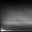

max:


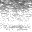

random selection:


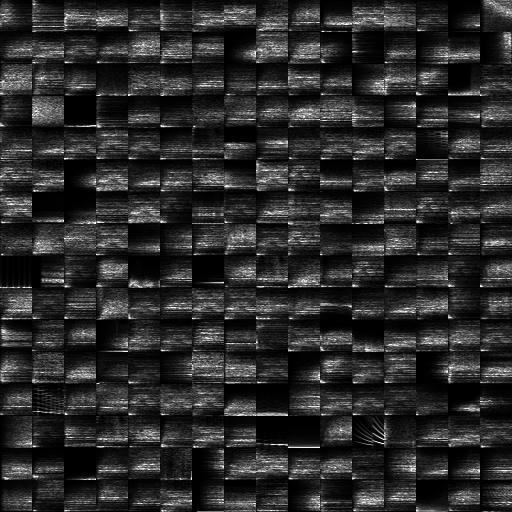

In [23]:
print 'data shape:', np.shape(fingerprints)

mean = np.mean(fingerprints, axis=0)
mean -= mean.min()
mean /= mean.max()

print 'mean:'
show_array(255 * mean)
print 'max:'
show_array(255 * np.max(fingerprints, axis=0))

print 'random selection:'
indices = range(len(fingerprints))
np.random.shuffle(indices)
show_array(255 * make_mosaic(np.array(fingerprints)[indices], n=16))